In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model = tf.keras.models.load_model('X-ray-VGG19-Best-model.h5')

# Identify the last convolutional layer in your model (change 'block5_conv4' if necessary)
last_conv_layer = model.get_layer('block5_conv4')

# Build a model that maps the input image to the activations of the last conv layer
grad_model = Model(inputs=model.inputs,
                   outputs=[last_conv_layer.output, model.output])


In [ ]:
# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # VGG16 input size
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [ ]:
# Load a sample image for prediction
test_images_dir = '/content/preprocessed_data/test'
results = []

# Dictionary to map class indices to class names
classes = {
    'Normal': 0,
    'Lung_Opacity': 1,
    'COVID-19': 2,
    'Tuberculosis': 3,
    'Pneumonia_Viral': 4,
    'Pneumonia-Bacterial': 5
}


In [ ]:
print(predictions.shape)
loss = predictions[0, predicted_class]  # Access the predicted class


(1, 6)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions shape: (1, 6)
Generated heatmap shape: (14, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predictions shape: (1, 6)
Generated heatmap shape: (14, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predictions shape: (1, 6)
Generated heatmap shape: (14, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predictions shape: (1, 6)
Generated heatmap shape: (14, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predictions shape: (1, 6)
Generated heatmap shape: (14, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predictions shape: (1, 6)
Generated heatmap shape: (14, 14)


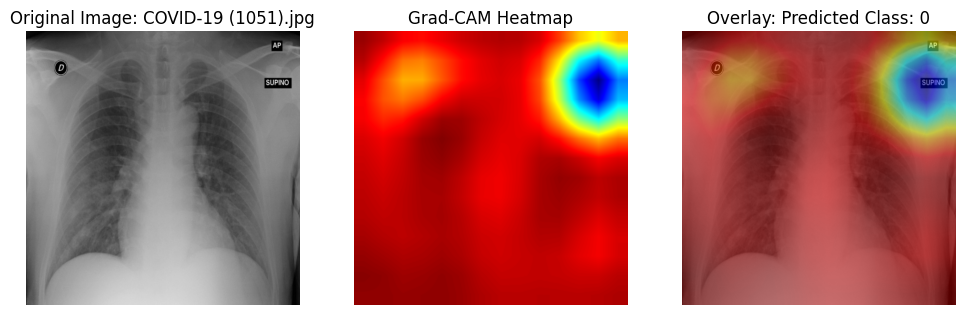

Image: COVID-19 (1051).jpg, Predicted Class: 0, Link: /content/preprocessed_data/test/COVID-19/COVID-19 (1051).jpg


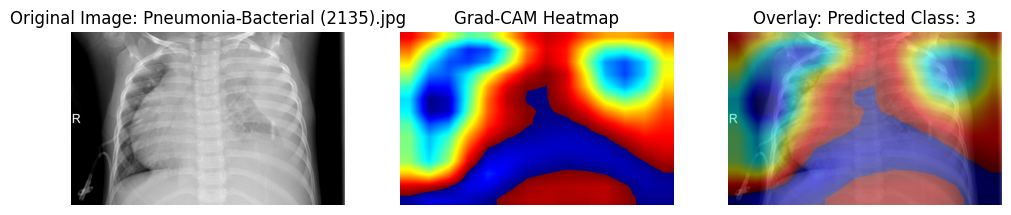

Image: Pneumonia-Bacterial (2135).jpg, Predicted Class: 3, Link: /content/preprocessed_data/test/Pneumonia-Bacterial/Pneumonia-Bacterial (2135).jpg


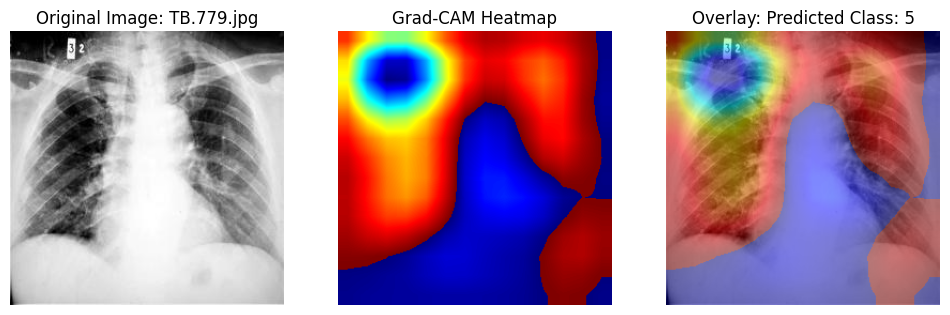

Image: TB.779.jpg, Predicted Class: 5, Link: /content/preprocessed_data/test/Tuberculosis/TB.779.jpg


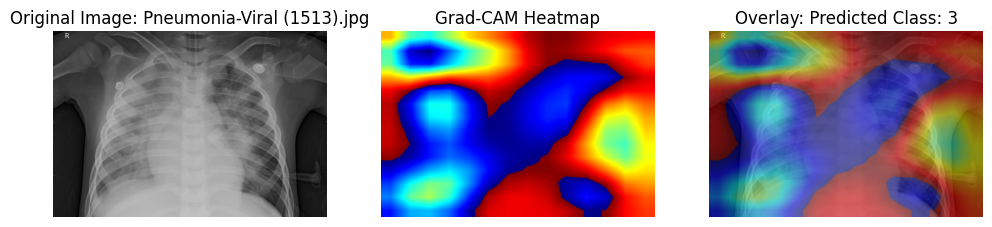

Image: Pneumonia-Viral (1513).jpg, Predicted Class: 3, Link: /content/preprocessed_data/test/Pneumonia_Viral/Pneumonia-Viral (1513).jpg


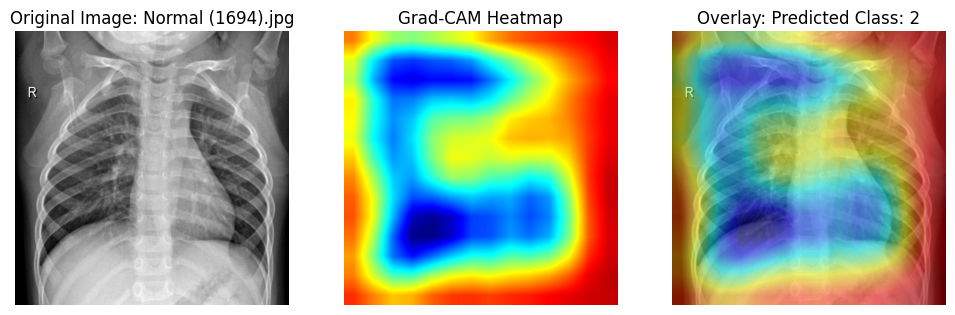

Image: Normal (1694).jpg, Predicted Class: 2, Link: /content/preprocessed_data/test/Normal/Normal (1694).jpg


In [ ]:
def generate_grad_cam(model, img_array, predicted_class):
    last_conv_layer = model.get_layer('block5_conv4')  # Adjust layer name if needed

    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # Convert predictions to a tensor if it's a list
        if isinstance(predictions, list):
            predictions = predictions[0]

        print(f"Predictions shape: {predictions.shape}")  # Debugging output

        if predicted_class < predictions.shape[1]:
            loss = predictions[0, predicted_class]
        else:
            raise ValueError(f"predicted_class {predicted_class} is out of bounds for predictions shape {predictions.shape}.")

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Convert heatmap to a NumPy array
    heatmap = heatmap.numpy()  # Convert to numpy array

    if np.max(heatmap) != 0:  # Normalize to avoid division by zero
        heatmap /= np.max(heatmap)

    print(f"Generated heatmap shape: {heatmap.shape}")  # Debugging output

    return heatmap


# Inside the loop for generating Grad-CAM results
for filename in sampled_files:
    image_path = os.path.join(class_path, filename)

    img_array = preprocess_image(image_path)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Make sure predicted_class is within valid range
    if predicted_class < len(classes):
        heatmap = generate_grad_cam(model, img_array, predicted_class)

        original_image = load_img(image_path)

        # The rest of your code follows...



# Directory containing test images
test_images_dir = '/content/preprocessed_data/test'

# Get list of class directories
class_dirs = [d for d in os.listdir(test_images_dir) if os.path.isdir(os.path.join(test_images_dir, d))]

# Set a sample size for each class
sample_size = 1

results = []

# Inside the loop for generating Grad-CAM results
for class_dir in class_dirs:
    class_path = os.path.join(test_images_dir, class_dir)

    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    sampled_files = random.sample(image_files, min(sample_size, len(image_files)))

    for filename in sampled_files:
        image_path = os.path.join(class_path, filename)

        img_array = preprocess_image(image_path)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])

        heatmap = generate_grad_cam(model, img_array, predicted_class)

        original_image = load_img(image_path)

        # Ensure heatmap is a NumPy array before resizing
        if isinstance(heatmap, np.ndarray):
            heatmap_resized = cv2.resize(heatmap, (original_image.size[0], original_image.size[1]))
            heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        else:
            raise ValueError(f"Heatmap is not a valid numpy array: {type(heatmap)}")

        # Normalize original image for overlay
        original_image_np = img_to_array(original_image) / 255.0
        heatmap_color_float = heatmap_color.astype(np.float32) / 255.0

        # Overlay heatmap on original image
        overlayed_image = cv2.addWeighted(heatmap_color_float, 0.5, original_image_np, 0.5, 0)

        # Append results with image link
        results.append((filename, predicted_class, image_path, original_image, overlayed_image, heatmap_color))

# Display results for each sampled image with heatmaps
for filename, predicted_class, image_link, original_image, overlayed_image, heatmap_color in results:
    plt.figure(figsize=(12, 6))

    # Display Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image: {filename}')
    plt.axis('off')

    # Display Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_color)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    # Display Overlayed Image
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title(f'Overlay: Predicted Class: {predicted_class}')
    plt.axis('off')

    plt.show()

    # Print the image link
    print(f'Image: {filename}, Predicted Class: {predicted_class}, Link: {image_link}')